## Уравнение переноса


Основные понятия сопоставлял и смотрел тут: 

https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/advection.pdf

https://homepages.math.uic.edu/~jan/mcs471f21/wavepde.pdf


Для сравнения результатов: http://math.phys.msu.ru/archive/2015_2016/374/tema5.pdf

In [63]:
import numpy as np
import math

class Dim:
    def __init__(self, length, pts_num, step=0.0):
        self.len = length
        self.pts_num = pts_num
        self.step = step if step else length / pts_num

class Dimensions:
    def __init__(self, x, t):
        self.x = x
        self.t = t

class DataXY:
    def __init__(self, dims, d_coeff):
        self.data = np.zeros((dims.x.pts_num, dims.t.pts_num))
        self.d = dims
        self.d_coeff = d_coeff

def calculate_new_point_lax_wendroff(state, x_pos, y_pos):
    data = state.data

    r_side = (data[x_pos + 1, y_pos] - 2 * data[x_pos, y_pos] + data[x_pos - 1, y_pos]) / state.d.x.step ** 2

    return data[x_pos, y_pos] + state.d.t.step * state.d_coeff * r_side

def calculate_new_point_upwind(state, x_pos, y_pos):
    data = state.data
    return data[x_pos, y_pos] - state.d_coeff * (data[x_pos, y_pos] - data[x_pos - 1, y_pos])

def calculate_new_point_rect(state, x_pos, y_pos):
    delta_x = state.d.x.step
    delta_t = state.d.t.step
    x = (x_pos - 0.5) * delta_x
    t = (y_pos - 0.5) * delta_t

   
    next_value = 0.5 * ((state.data[x_pos, y_pos] + state.data[x_pos+1, y_pos]) / delta_t + 
                         (state.data[x_pos, y_pos+1] + state.data[x_pos+1, y_pos+1]) / delta_t) + \
                 ((state.data[x_pos+1, y_pos+1] - state.data[x_pos+1, y_pos]) / delta_x + 
                  (state.data[x_pos, y_pos+1] - state.data[x_pos, y_pos]) / delta_x) - \
                 (x + 0.5 * delta_x) - (t + 0.5 * delta_t)
    
    return state.data[x_pos, y_pos] - next_value 

def calculate_row(state, row, method="lax"):
    if row < 1 or row >= state.d.t.pts_num: return
    if method == "lax":
        for i in range(1, state.d.x.pts_num - 1):
            state.data[i, row] = calculate_new_point_lax_wendroff(state, i, row - 1)
    elif method == "angle":
        for i in range(1, state.d.x.pts_num - 1):
            state.data[i, row] = calculate_new_point_upwind(state, i, row - 1)
    elif method == "rect":
        for i in range(1, state.d.x.pts_num - 1):
            state.data[i, row] = calculate_new_point_rect(state, i, row - 1)

def init_start_coord_dim(state, step):
    for i in range(state.d.x.pts_num):
        state.data[i, 0] = math.cos(step * i * np.pi)

def init_start_time_dim(state, step):
    for i in range(state.d.t.pts_num):
        state.data[0, i] = math.exp(-i*step)


In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_state(data):
    """
    1. График плотности state(x, t)
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(data, extent=[0, data.shape[1], 0, data.shape[0]], origin='lower', aspect='auto', cmap='hot')
    plt.colorbar(label='State')
    plt.xlabel('Time Index')
    plt.ylabel('X Index')
    plt.title('State(x, t)')
    plt.show()

def plot_state_at_times(data, x_dim, t_dim):
    """
    2. 3 графика f(x, t) от x при t=0, t=middle_value, t=end_value
    """
    plt.figure(figsize=(14, 6))
    
    times = [0, t_dim.pts_num // 2, t_dim.pts_num - 1]
    labels = ['t=0', 't=Middle', 't=End']
    
    for i, time in enumerate(times):
        plt.plot(range(x_dim.pts_num), data[:, time], label=f'{labels[i]} (index {time})')
    
    plt.legend()
    plt.xlabel('X Index')
    plt.ylabel('State')
    plt.title('State at Different Times')
    plt.show()

def plot_3d_state(data, x_dim, t_dim):
    """
    3. Трёхмерный график x, t, f(x, t)
    """
    x = np.arange(0, x_dim.pts_num)
    t = np.arange(0, t_dim.pts_num)
    X, T = np.meshgrid(x, t)
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, data.T, cmap='viridis')
    
    ax.set_xlabel('X Index')
    ax.set_ylabel('Time Index')
    ax.set_zlabel('State')
    ax.set_title('3D State Evolution')
    plt.show()



## Lax-Wendroff scheme 

<img src="img/central_scheme.png" width=700 />

In [58]:

x_dim = Dim(1.0, 1000)
t_dim = Dim(20.0, 100000)

dims = Dimensions(x_dim, t_dim)
state = DataXY(dims, 1e-3)

init_start_coord_dim(state, x_dim.step)
init_start_time_dim(state, t_dim.step)

# Set the initial conditions at the end of the grid for the time space
for i in range(1, t_dim.pts_num):
    state.data[x_dim.pts_num - 1, i] = state.data[x_dim.pts_num - 1, 0] - (t_dim.step * i)

print("Initial cond finished")
# Compute values for each row
for row in range(1, t_dim.pts_num):
    calculate_row(state, row, "lax")

Initial cond finished


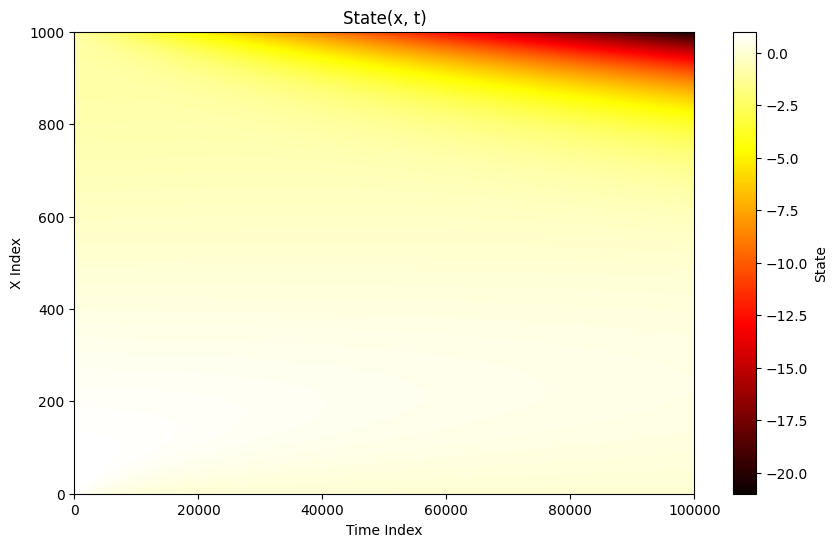

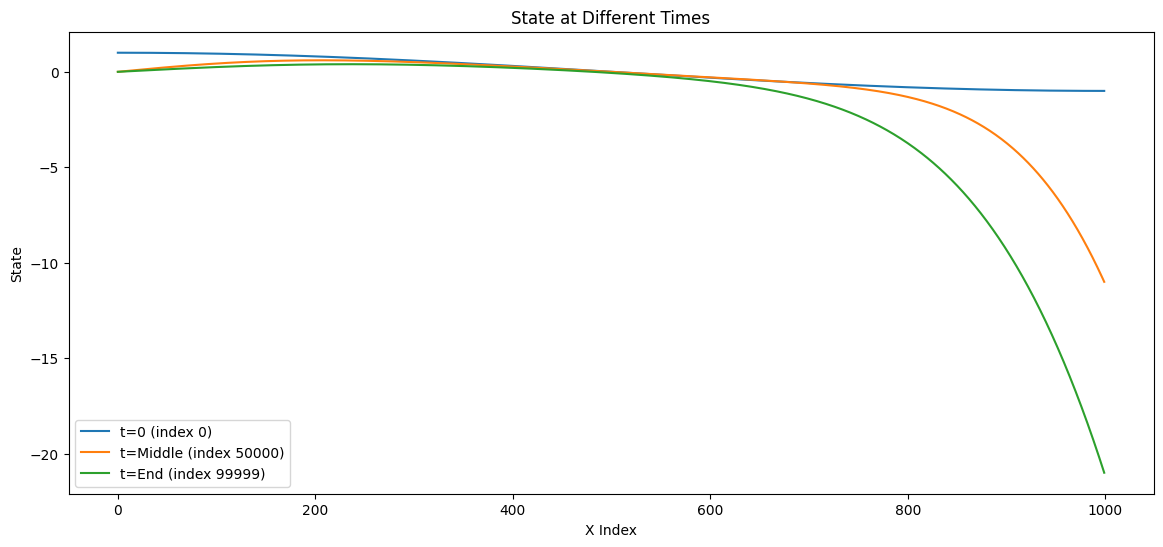

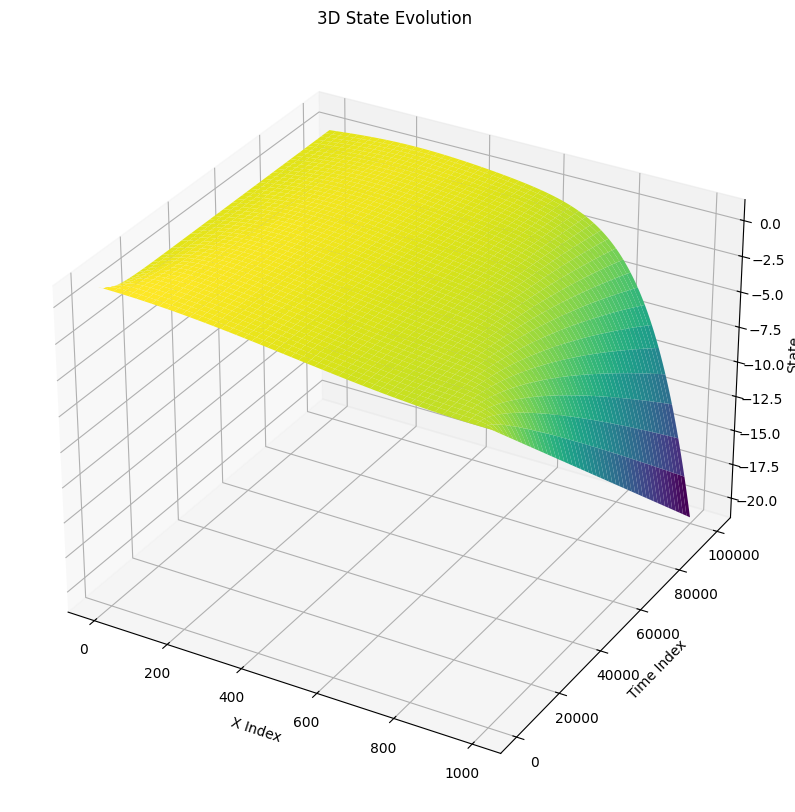

In [59]:
plot_state(state.data)
plot_state_at_times(state.data, x_dim, t_dim)
plot_3d_state(state.data, x_dim, t_dim)


## Upwind scheme 


<img src="img/angle.png" width=700 />

In [37]:
x_dim = Dim(1.0, 1000)
t_dim = Dim(20.0, 100000)

dims = Dimensions(x_dim, t_dim)
state = DataXY(dims, 1e-3)

init_start_coord_dim(state, x_dim.step)
init_start_time_dim(state, t_dim.step)

# Set the initial conditions at the end of the grid for the time space
for i in range(1, t_dim.pts_num):
    state.data[x_dim.pts_num - 1, i] = state.data[x_dim.pts_num - 1, 0] - (t_dim.step * i)

print("Initial cond finished")
# Compute values for each row
for row in range(1, t_dim.pts_num):
    calculate_row(state, row, "angle")

Initial cond finished


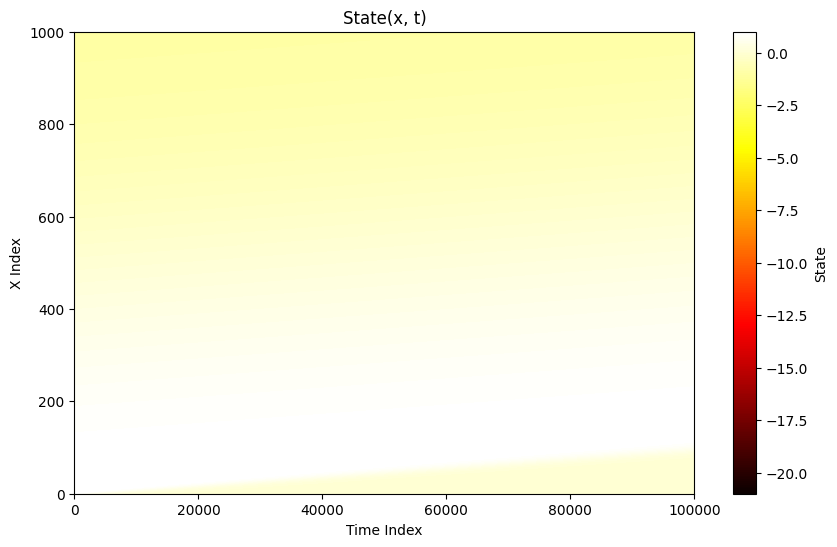

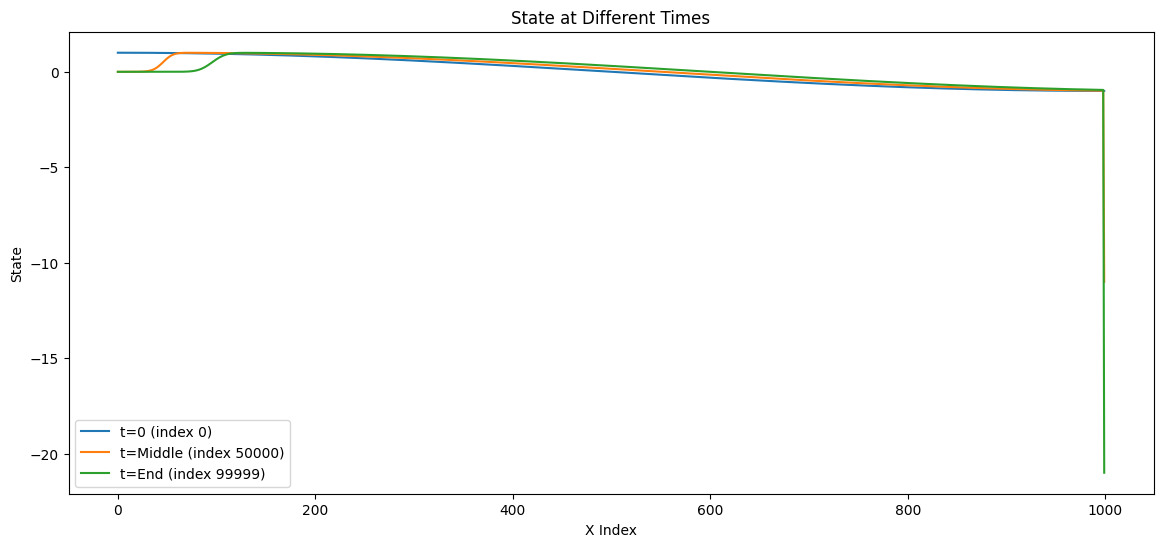

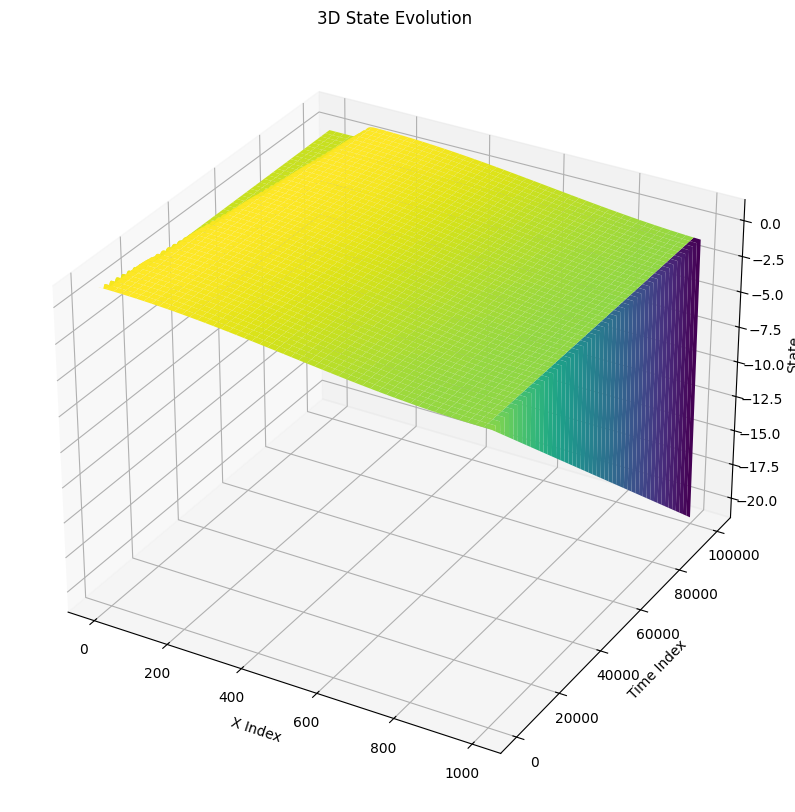

In [38]:
plot_state(state.data)
plot_state_at_times(state.data, x_dim, t_dim)
plot_3d_state(state.data, x_dim, t_dim)


## Rectangle scheme (Не завёлся)

<img src="img/rectangle.png" width=700 />

In [61]:
x_dim = Dim(1.0, 1000)
t_dim = Dim(20.0, 100000)

dims = Dimensions(x_dim, t_dim)
state = DataXY(dims, 1e-3)

init_start_coord_dim(state, x_dim.step)
init_start_time_dim(state, t_dim.step)

# Set the initial conditions at the end of the grid for the time space
for i in range(1, t_dim.pts_num):
    state.data[x_dim.pts_num - 1, i] = state.data[x_dim.pts_num - 1, 0] - (t_dim.step * i)

print("Initial cond finished")
# Compute values for each row
for row in range(1, t_dim.pts_num):
    calculate_row(state, row, "rect")

Initial cond finished


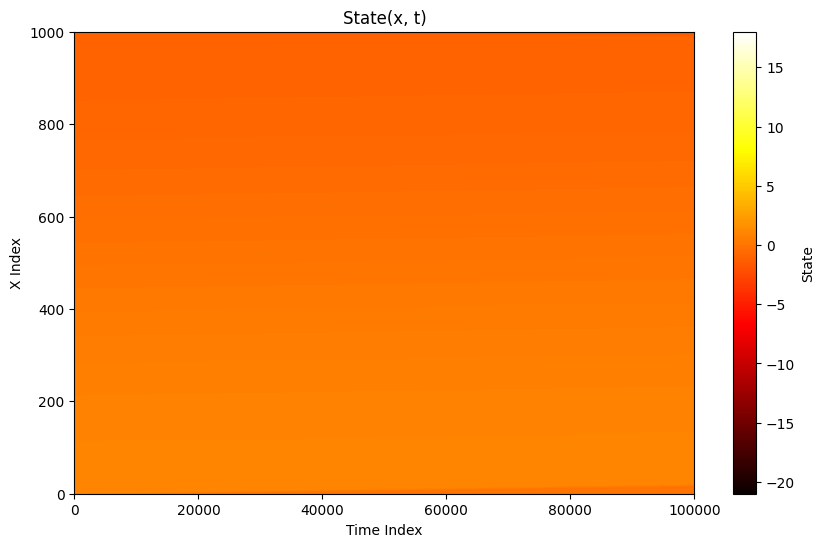

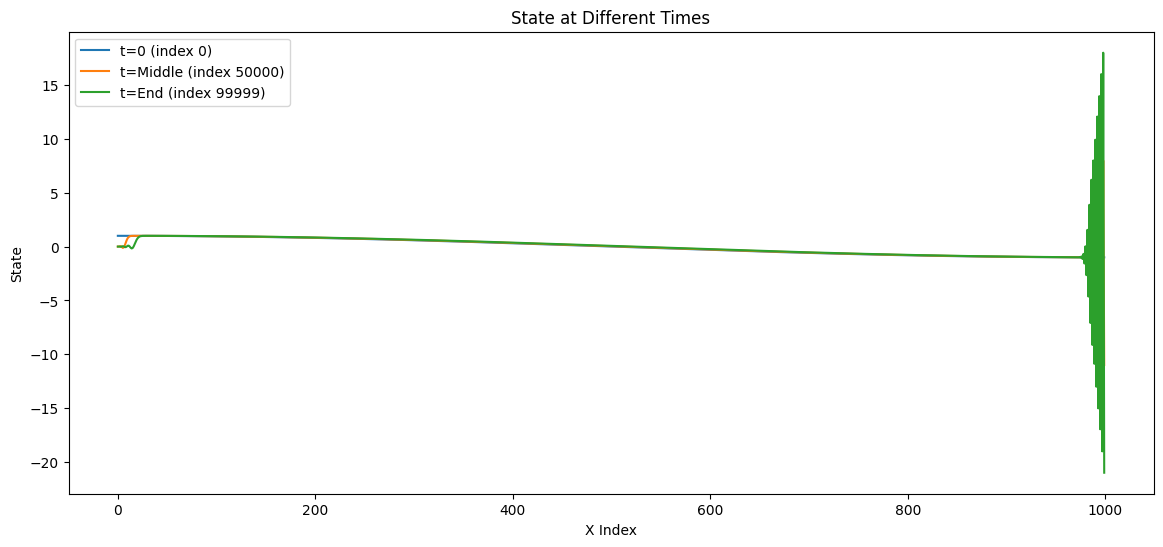

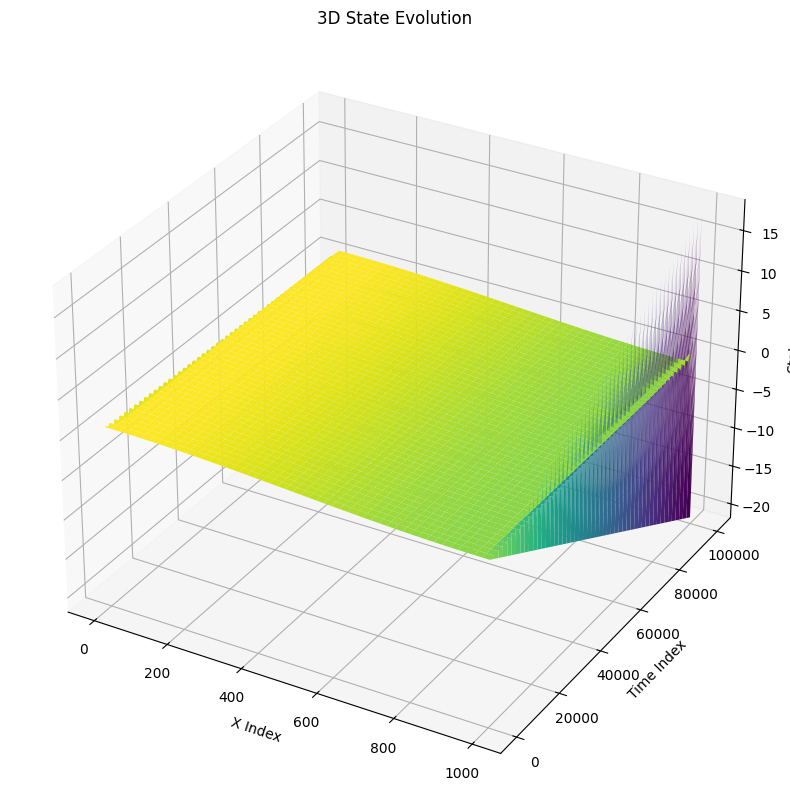

In [62]:
plot_state(state.data)
plot_state_at_times(state.data, x_dim, t_dim)
plot_3d_state(state.data, x_dim, t_dim)
